# Workflows - Prompt Chaining

## What are workflows?

To recap, workflows are systems where LLMs and tools are orchestrated through predefined code paths.

## What is prompt Chaining?

[According to Anthropic](https://www.anthropic.com/research/building-effective-agents), Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

## Implementation & use case

In this notebook, we will implement a prompt chaining workflow. The workflow will be comprised of 3 steps:

1. Load local pdf files (similarly to the [Directly calling LLMs](1-DirectCall.ipynb) notebook)
2. We will then use a LLM to summarize their content in discrete pieces (or chunks), called that I arbitrarely named `Sections`.
3. We will then pass all `Sections` to a LLM to identify the main topics across all files.

This is how it should look like after implementing it:

![workflow-prompt-chaining](images/workflow-prompt-chaining.png)

We will use LangChain to abstract away the LLM integration and we will use LangGraph to build the workflows.

## What is LangGraph?

Before moving forward, I think it is a good idea to spend some time explain what LangGraph is and what are their main components.

[LangGraph](https://langchain-ai.github.io/langgraph/) is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.

There are 3 main concepts that are foundamental to LangGraph that we will use on this (and the following) notebooks:
- State: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.
- Nodes: Python functions that encode the logic of your agents. They receive the current State as input, perform some computation or side-effect, and return an updated State.
- Edges: Python functions that determine which Node to execute next based on the current State. They can be conditional branches or fixed transitions.

In short: nodes do the work. edges tell what to do next.

## Lets build a workflow with LangGraph!

Let's start by installing some dependencies

In [ ]:
%pip install -r requirements.txt

Since we already have the  `FileContent` and `FileSummary` classes, we can import them and use them straight away.

We will define a new class to store the list of main topics identified, `Topic`. We will also define a `TopicList` as a data class to host the list of `Topic`. This will be used for schema validation for the LLM.

In [ ]:
from pydantic import BaseModel, Field
from typing import List, Iterator

class Topic(BaseModel):
    name: str = Field(
        description="The name of the topic.",
        min_length = 1,
        max_length = 50
    )
    description: str = Field(
        description="The description of the topic.",
        min_length = 10,
        max_length = 100
    )

class TopicList(BaseModel):
    topics: List[Topic] = Field(
        description="List of main topics identified from the file",
        min_items=1
    )

    # Iterator object
    def __iter__(self) -> Iterator[Topic]:
        return iter(self.topics)
    
    # To allow splicing
    def __getitem__(self, index: int) -> Topic:
        return self.topics[index]

With all the classes needed defined, let's define the shared State for LangGraph.

This State will need to store:
1. A list of files we want to use
2. The content of said files. We can use the `FileContent` class to store this data.
3. The summarized pieces of content, with its title. We can use the `Section` class for it.
4. The main topics identified accross all `Sections`.

In [ ]:
from pydantic import BaseModel
from typing import List
from langchain_core.language_models import BaseLanguageModel
from utils import FileContent, FileSummary, read_files, summarize_files

# Initializing empty state
class State(BaseModel):
    file_list: List[str] = []
    file_contents: List[FileContent] = []
    summarized_files: List[FileSummary] = []
    main_topics: TopicList = []

Since we already have the  `read_files` and `summarize_files` functions defined, we can import them and use them straight away.

We will need to define a new function to identify the main topics.

In [ ]:
from langchain_core.language_models import BaseLanguageModel
from langchain.prompts import PromptTemplate

def return_main_topic_identification_prompt() -> str:
    """
    Returns the prompt used for main topic identification
    
    Args:
        none

    Returns:
        str: The prompt used for main topic identification
    """
    template = """

    <text>{text}</text>

    You are an expert at analyzing text to identify main topics.
    Analyze the text contained within the <text> tags and identify
    the main topics across all text. There could be multiple main
    topics. For each topic provide:
    - its name
    - a brief description (less than 100 characters)
    """
    prompt = PromptTemplate(
        input_variables = ["text"],
        template=template
    )

    return prompt

def identify_main_topics(summary_list: List[FileSummary], llm: BaseLanguageModel) -> List[Topic]:
    """
    Identify the main topics within a list of FileSummary using an LLM and retuns a list of Topic.
    
    Args:
        summary_list: List[FileSummary]: the list of summaries to from which identify main topics
        llm (BaseLanguageModel): an LLM to use for identifying main topics

    Returns:
        List[Topic]: List of the main topics identified on the summaries
    """

    structured_llm = llm.with_structured_output(TopicList)

    prompt = return_main_topic_identification_prompt()

    text = '\n'.join(
        f"{section.title}: {section.summary}"
        for file_summary in summary_list
        for section in file_summary.sections
    )

    main_topics = structured_llm.invoke(prompt.format(text=text))

    return main_topics

I'll go ahead and save those classes to the `utils.py` file to re-use them later.

Lets build some wrapper functions that will act as nodes in the Graph.

In [ ]:
import asyncio

async def load_files(state: State) -> State:
    return {"file_contents": await read_files(state.file_list)}

def summarize_all_files(state: State) -> State:
    return {"summarized_files": summarize_files(file_list=state.file_contents, llm=llm)}

def iden_main_topics(state: State) -> State:
    return {"main_topics": identify_main_topics(state.summarized_files, llm=llm)}

Let's build the Graph

In [ ]:
from langgraph.graph import StateGraph, START, END

# Build the state graph
builder = StateGraph(State)

# add nodes
builder.add_node(load_files)
builder.add_node(summarize_all_files)
builder.add_node(iden_main_topics)

builder.add_edge(START, "load_files")
builder.add_edge("load_files", "summarize_all_files")
builder.add_edge("summarize_all_files", "iden_main_topics")
builder.add_edge("iden_main_topics", END)
graph = builder.compile()

We have built the graph! We can take advantage of a feature in LangGraph to see how it looks like.

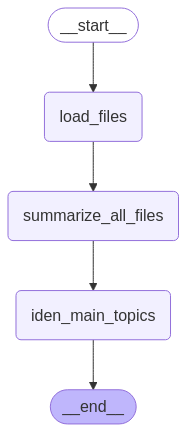

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Looks all right! Let's load some files and test it

We will load the files using the `load_files` function we defined on the first notebook. You can head to [Directly calling LLMs](1-DirectCall.ipynb) for more info about this function.

In [7]:
import os

base_dir = os.path.expanduser('~/Desktop/pdfs')

input_files = \
    [
        os.path.join(base_dir, "1.pdf"),
        os.path.join(base_dir, "2.pdf"),
        os.path.join(base_dir, "3.pdf"),
        os.path.join(base_dir, "4.pdf"),
        os.path.join(base_dir, "5.pdf")
]

Let's define the LLM we will use. I am using a local LLM hosted with LM Studio that has an OpenAI compatible API. You can change the below line to whatever LLM you want to use.

In [8]:
from utils import load_llm
llm = load_llm()

Loading LLM...
Parameters:
max_tokens: 8192, temperature: 0.1, top_p: 0.4
Using Anthropic. Model: claude-3-5-haiku-20241022


## Time to test it!

We have now everything we need to test the graph. Let's test it!

In [ ]:
result = await graph.ainvoke({"file_list": input_files})

Let's check the results:

In [10]:
result['main_topics']

TopicList(topics=[Topic(name='LangGraph', description='Framework for modeling complex agent workflows using graph-based architecture'), Topic(name='AI Model Training', description='Fundamental techniques for developing and training large language models'), Topic(name='AI Reasoning and Emergence', description="Exploring AI's ability to develop reasoning capabilities and logical thinking"), Topic(name='Transformers Library', description='Hugging Face library for working with machine learning models'), Topic(name='AI Industry Updates', description='Recent developments and trends in artificial intelligence technology'), Topic(name='Productivity AI Tools', description='AI-powered tools designed to enhance work efficiency and workflow')])